<a href="https://colab.research.google.com/github/lisabecker/nlp-fundamentals/blob/main/0204_who_wrote_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Who wrote it? Authorship Attribution with NLP

In this exercise, we check out heuristic authorship attribution, a method that combines linguistic analysis with data science to identify the author of a given text. This approach goes beyond the content, focusing on unique stylistic and linguistic patterns that characterize an author's writing. By analyzing features like word choice, sentence structure, and stylistic elements, we can employ computational techniques to make educated guesses about the authorship of unknown or disputed texts. In this notebook, we'll explore various heuristic methods, from simple word frequency analysis to more complex syntactic patterns, discovering the hidden signatures authors leave in their writing.

## 1. Setting up the environment

In [1]:
!pip install --q requests beautifulsoup4 nltk

## 2. Downloading and Preparing Texts

In this section, we download classic texts from Project Gutenberg using the `requests` library and parse the HTML content with `BeautifulSoup` to extract the text. We specifically target the main content of the books by locating the start and end markers of the Project Gutenberg texts. This approach ensures that we only work with the actual content of the books, excluding headers and footers added by Project Gutenberg.

The books chosen for this analysis are Jane Austen's "Pride and Prejudice" and William Blake's "Songs of Innocence and of Experience." After downloading, we save the texts to files for easier access in subsequent steps of our analysis.


In [2]:
import requests
from bs4 import BeautifulSoup

def download_book(url):
    """Download the text of a book from Project Gutenberg."""
    response = requests.get(url, timeout=120)
    response.raise_for_status()  # Raise an error for bad status codes

    soup = BeautifulSoup(response.content, 'html.parser')
    text = soup.get_text()
    start_marker = '*** START OF THE PROJECT GUTENBERG EBOOK'
    end_marker = '*** END OF THE PROJECT GUTENBERG EBOOK'

    # Find the indices of the start and end markers
    start = text.find(start_marker)
    end = text.find(end_marker)
    if start != -1 and end != -1:
      # Adjust the start index to not include the start marker itself
      start += len(start_marker)
      # Slice the text to get the content between the markers
    return text[start:end].strip()

# URLs of the books from Project Gutenberg
austen_url = 'https://www.gutenberg.org/files/1342/1342-0.txt'  # Pride and Prejudice
blake_url = 'https://www.gutenberg.org/cache/epub/1934/pg1934.txt' # Songs of Innocence and of Experience

# Download the books
pride_and_prejudice = download_book(austen_url)
songs_of_innocence = download_book(blake_url)

# Optionally, save the texts to files
with open('Pride_and_Prejudice.txt', 'w', encoding='utf-8') as f:
    f.write(pride_and_prejudice)

with open('Songs_of_Innocence_and_of_Experience.txt', 'w', encoding='utf-8') as f:
    f.write(songs_of_innocence)

print("Books downloaded and saved.")

Books downloaded and saved.


In [3]:
# Load the texts (assuming they were saved in the previous step)
with open('Pride_and_Prejudice.txt', 'r', encoding='utf-8') as f:
    pride_and_prejudice_text = f.read()
    start = pride_and_prejudice_text.find("It is a truth universally acknowledged")
    pride_and_prejudice_text = pride_and_prejudice_text[start:]

with open('Songs_of_Innocence_and_of_Experience.txt', 'r', encoding='utf-8') as f:
    songs_of_innocence_text = f.read()
    start = songs_of_innocence_text.find("Piping down the valleys wild")
    songs_of_innocence_text = songs_of_innocence_text[start:]

print("Books loaded into memory.")

Books loaded into memory.


In [4]:
pride_and_prejudice_sample = pride_and_prejudice_text[:116]
songs_of_innocence_sample = songs_of_innocence_text[:151]
print(f"Start of Pride and Prejudice:\n'{pride_and_prejudice_sample}'\n")
print(f"Start of Songs of Innocence and of Experience:\n'{songs_of_innocence_sample}'")

Start of Pride and Prejudice:
'It is a truth universally acknowledged, that a single man in possession
of a good fortune must be in want of a wife.'

Start of Songs of Innocence and of Experience:
'Piping down the valleys wild,
    Piping songs of pleasant glee,
On a cloud I saw a child,
    And he laughing said to me:

‘Pipe a song about a Lamb!’'


## 3. Text Processing and Tokenization

Here, we conduct initial text processing tasks essential for authorship attribution analysis. Using the Natural Language Toolkit (NLTK), we first download necessary components like `punkt` for tokenization and `stopwords` to filter out common words.

We demonstrate the text preprocessing steps on a sample from "Songs of Innocence and of Experience," including:
- Converting all letters to lowercase.
- Removing punctuation.
- Splitting the text into tokens (words).
- Removing stopwords (common words that usually don't carry much meaning).

Furthermore, we define functions `clean_text` and `remove_stopwords` to standardize and streamline these preprocessing steps. We then apply these functions to the entire texts of "Pride and Prejudice" and "Songs of Innocence and of Experience" to prepare them for the next steps in our analysis.


In [5]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
print("All letters set to lowercase:")
songs_of_innocence_sample.lower()

All letters set to lowercase:


'piping down the valleys wild,\n    piping songs of pleasant glee,\non a cloud i saw a child,\n    and he laughing said to me:\n\n‘pipe a song about a lamb!’'

In [7]:
print("Punctuation removed:")
re.sub(r'[^a-zA-Z\s]', '', songs_of_innocence_sample)

Punctuation removed:


'Piping down the valleys wild\n    Piping songs of pleasant glee\nOn a cloud I saw a child\n    And he laughing said to me\n\nPipe a song about a Lamb'

In [8]:
print("Text split into tokens:")
tokens = word_tokenize(songs_of_innocence_sample)
print(tokens)

Text split into tokens:
['Piping', 'down', 'the', 'valleys', 'wild', ',', 'Piping', 'songs', 'of', 'pleasant', 'glee', ',', 'On', 'a', 'cloud', 'I', 'saw', 'a', 'child', ',', 'And', 'he', 'laughing', 'said', 'to', 'me', ':', '‘', 'Pipe', 'a', 'song', 'about', 'a', 'Lamb', '!', '’']


In [9]:
print("Stopwords removed:")
stop_words = set(stopwords.words('english'))
print([token for token in tokens if token not in stop_words])

Stopwords removed:
['Piping', 'valleys', 'wild', ',', 'Piping', 'songs', 'pleasant', 'glee', ',', 'On', 'cloud', 'I', 'saw', 'child', ',', 'And', 'laughing', 'said', ':', '‘', 'Pipe', 'song', 'Lamb', '!', '’']


In [10]:
def clean_text(text):
    """ Clean and tokenize text. """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    return text

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

pride_and_prejudice_cleaned = clean_text(pride_and_prejudice_text)
songs_of_innocence_cleaned = clean_text(songs_of_innocence_text)

# Preprocess the texts
pride_and_prejudice_tokens = word_tokenize(pride_and_prejudice_cleaned)
songs_of_innocence_tokens = word_tokenize(songs_of_innocence_cleaned)

pride_and_prejudice_preprocessed = remove_stopwords(pride_and_prejudice_tokens)
songs_of_innocence_preprocessed = remove_stopwords(songs_of_innocence_tokens)

print("Pride and Prejudice - First 100 tokens:", pride_and_prejudice_preprocessed[:100])
print("Songs of Innocence and of Expectations - First 100 tokens:", songs_of_innocence_preprocessed[:100])

Pride and Prejudice - First 100 tokens: ['truth', 'universally', 'acknowledged', 'single', 'man', 'possession', 'good', 'fortune', 'must', 'want', 'wife', 'however', 'little', 'known', 'feelings', 'views', 'man', 'may', 'first', 'entering', 'neighbourhood', 'truth', 'well', 'fixed', 'minds', 'surrounding', 'families', 'considered', 'rightful', 'property', 'one', 'daughters', 'dear', 'mr', 'bennet', 'said', 'lady', 'one', 'day', 'heard', 'netherfield', 'park', 'let', 'last', 'mr', 'bennet', 'replied', 'returned', 'mrs', 'long', 'told', 'mr', 'bennet', 'made', 'answer', 'want', 'know', 'taken', 'cried', 'wife', 'impatiently', 'want', 'tell', 'objection', 'hearing', 'illustration', 'came', 'see', 'place', 'copyright', 'george', 'allen', 'invitation', 'enough', 'dear', 'must', 'know', 'mrs', 'long', 'says', 'netherfield', 'taken', 'young', 'man', 'large', 'fortune', 'north', 'england', 'came', 'monday', 'chaise', 'four', 'see', 'place', 'much', 'delighted', 'agreed', 'mr', 'morris', 'immed

## 4. Word Frequency Analysis and Zipf's Law

In this section, we perform a word frequency analysis on both raw and preprocessed texts. We use `Counter` from the collections module to count the occurrences of each word in the texts.

Zipf's Law in linguistics and information theory suggests that the frequency of any word is inversely proportional to its rank in the frequency table. To visualize this, we plot the top N most common words in both texts, comparing the frequency distributions with and without stopwords.

These visualizations help us understand the most dominant words in each author's text and provide insights into stylistic elements characteristic of each author's writing.

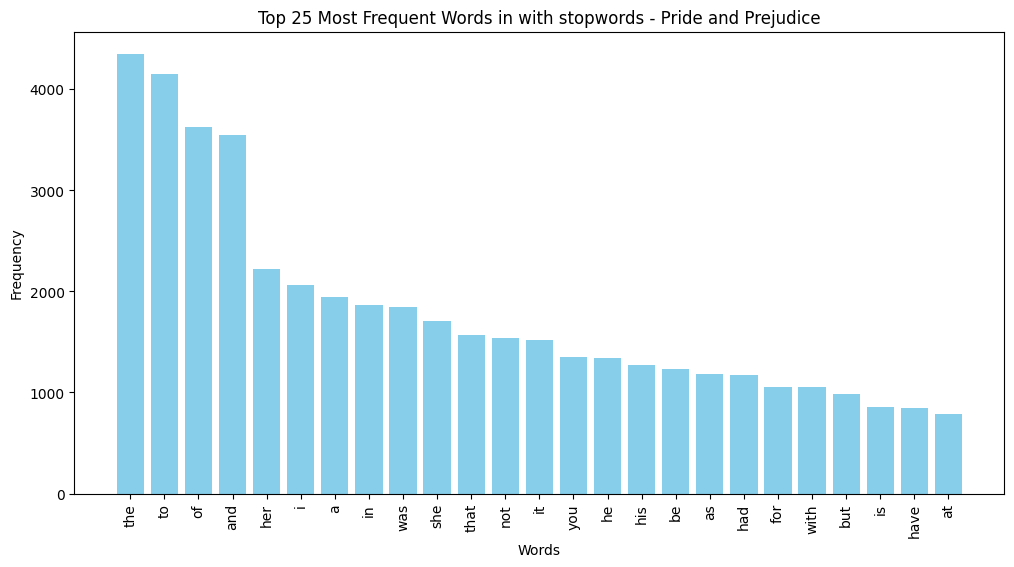

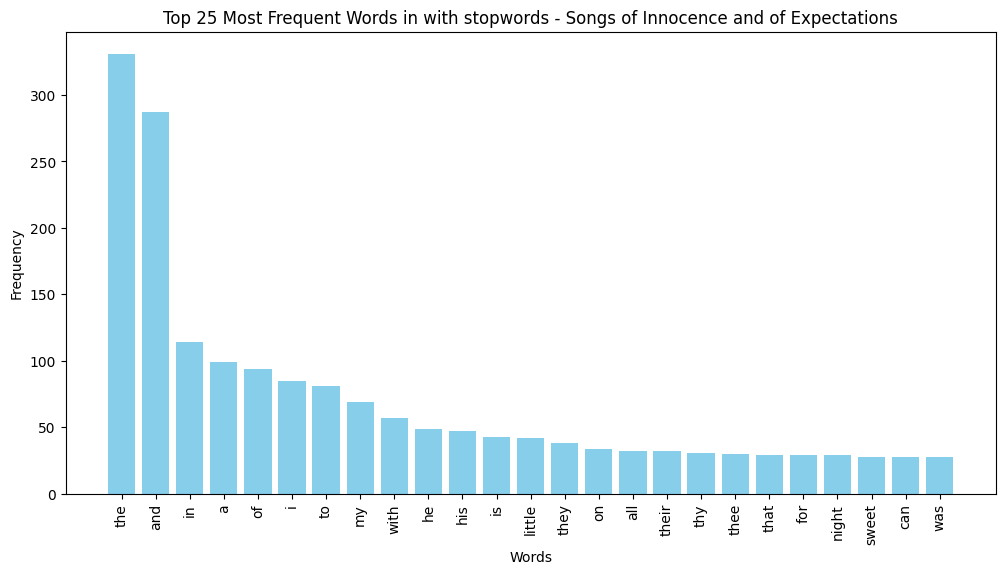

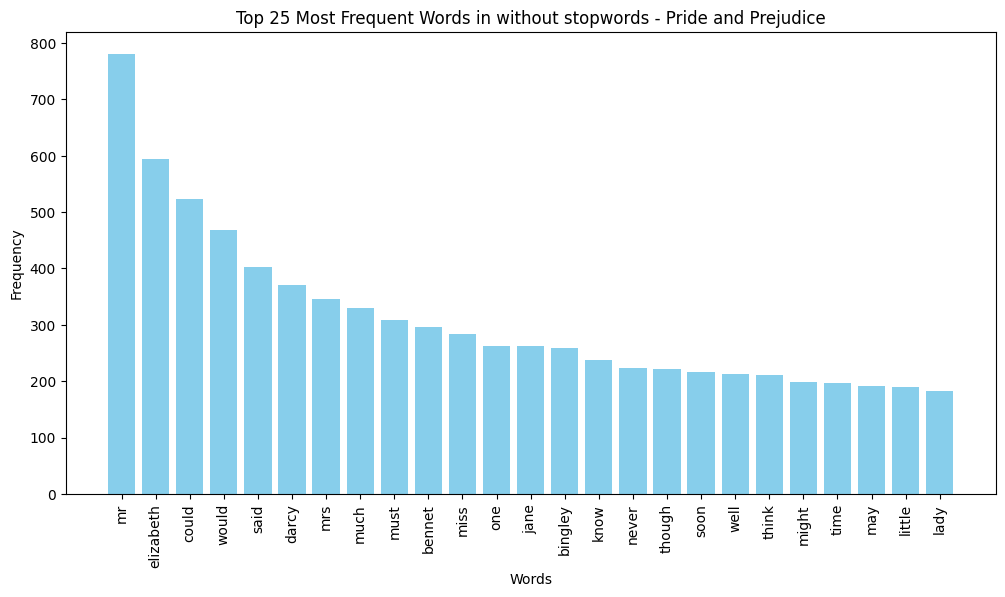

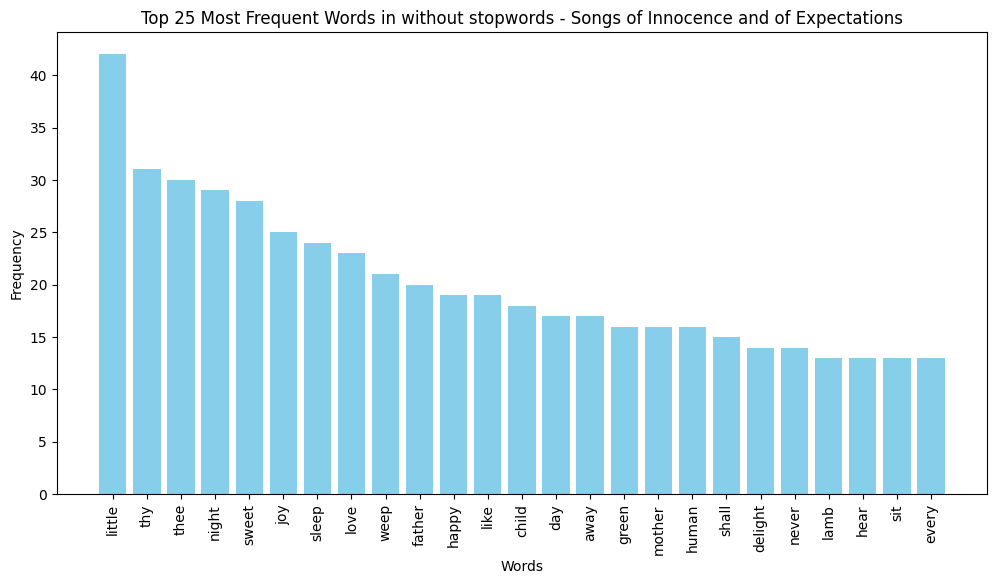

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

pride_and_prejudice_raw_word_freq = Counter(pride_and_prejudice_tokens)
pride_and_prejudice_wo_stopwords_word_freq = Counter(pride_and_prejudice_preprocessed)

songs_of_innocence_raw_word_freq = Counter(songs_of_innocence_tokens)
songs_of_innocence_wo_stopwords_word_freq = Counter(songs_of_innocence_preprocessed)

# Function to plot the top N most common words
def plot_top_words(word_freq, title, top_n=25):
    # Get top N most common words
    top_words = word_freq.most_common(top_n)
    words, freqs = zip(*top_words)

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate word labels for better readability
    plt.title(f'Top {top_n} Most Frequent Words in {title}')
    plt.show()

# Plot for raw text
plot_top_words(pride_and_prejudice_raw_word_freq, 'with stopwords - Pride and Prejudice')
plot_top_words(songs_of_innocence_raw_word_freq, 'with stopwords - Songs of Innocence and of Expectations')

# Plot for preprocessed text
plot_top_words(pride_and_prejudice_wo_stopwords_word_freq, 'without stopwords - Pride and Prejudice')
plot_top_words(songs_of_innocence_wo_stopwords_word_freq, 'without stopwords - Songs of Innocence and of Expectations')


## 5. Lexical Diversity and Sentence Complexity Analysis

Authorship attribution can be informed by analyzing various aspects of writing style, including lexical diversity and sentence complexity. Lexical diversity refers to the range of different words used in a text, often measured by the Type-Token Ratio (TTR). Sentence complexity, on the other hand, can be estimated by metrics like average sentence length and punctuation usage (e.g., commas and semicolons).

We calculate these metrics for both "Pride and Prejudice" and "Songs of Innocence and of Experience." This analysis provides a quantitative basis to compare and contrast the writing styles of Jane Austen and William Blake.


In [12]:
import numpy as np

def calculate_ttr(tokens):
    """ Calculate Type-Token Ratio (TTR) for lexical diversity. """
    types = set(tokens)
    return len(types) / len(tokens)

def calculate_avg_sentence_length(text):
    """ Calculate the average sentence length. """
    sentences = sent_tokenize(text)
    return sum(len(word_tokenize(sentence)) for sentence in sentences) / len(sentences)

def calculate_sentence_complexity(text):
    """ Calculate sentence complexity based on comma and semicolon usage. """
    sentences = sent_tokenize(text)
    punctuation_counts = sum(sentence.count(',') + sentence.count(';') for sentence in sentences)
    return punctuation_counts / len(sentences)

# Calculate metrics
austen_metrics = {
    'avg_sentence_length': calculate_avg_sentence_length(pride_and_prejudice_text),
    'ttr': calculate_ttr(pride_and_prejudice_tokens),
    'complexity': calculate_sentence_complexity(pride_and_prejudice_text)
}

blake_metrics = {
    'avg_sentence_length': calculate_avg_sentence_length(songs_of_innocence_text),
    'ttr': calculate_ttr(songs_of_innocence_tokens),
    'complexity': calculate_sentence_complexity(songs_of_innocence_text)
}

# Display some analysis results
print("Pride and Prejudice - Type-Token Ratio:", austen_metrics['ttr'])
print("Pride and Prejudice - Average Sentence Length in Words:", austen_metrics['avg_sentence_length'])
print("Pride and Prejudice - Sentence Complexity:", austen_metrics['complexity'])

print("Songs of Innocence and of Experience - Type-Token Ratio:", blake_metrics['ttr'])
print("Songs of Innocence and of Experience - Average Sentence Length in Words:", blake_metrics['avg_sentence_length'])
print("Songs of Innocence and of Experience - Sentence Complexity:", blake_metrics['complexity'])

Pride and Prejudice - Type-Token Ratio: 0.05501372279945109
Pride and Prejudice - Average Sentence Length in Words: 31.18470790378007
Pride and Prejudice - Sentence Complexity: 2.397121993127148
Songs of Innocence and of Experience - Type-Token Ratio: 0.23813953488372094
Songs of Innocence and of Experience - Average Sentence Length in Words: 25.8984375
Songs of Innocence and of Experience - Sentence Complexity: 2.7421875


## 6. Bag of Words Model for Authorship Attribution

The Bag of Words (BoW) model is a simple yet effective approach in natural language processing. It represents text data as the frequency of words without considering their order or context. In this section, we build a BoW model for both texts, focusing on the most frequent words used by each author.

We then define a function `authorship_attribution_bow` to predict the authorship of a given text snippet based on the frequency of characteristic words of each author. This heuristic approach compares the occurrences of an author's characteristic words in the snippet and attributes authorship to the one with the higher word frequency score.


In [13]:
from collections import Counter
from nltk.tokenize import word_tokenize

def get_word_frequencies(text):
    """Return a frequency distribution of words in the text."""
    tokens = word_tokenize(text)
    return Counter(tokens)

austen_freq_dist = get_word_frequencies(pride_and_prejudice_cleaned)
blake_freq_dist = get_word_frequencies(songs_of_innocence_cleaned)

def get_top_words(freq_dist, top_n=100):
    """Get top N words from a frequency distribution."""
    return [word for word, freq in freq_dist.most_common(top_n)]

# Get top N words from each author
top_n = 250
austen_characteristic_words = get_top_words(austen_freq_dist, top_n)
blake_characteristic_words = get_top_words(blake_freq_dist, top_n)

def authorship_attribution_bow(text, austen_words, blake_words):
    text_tokens = word_tokenize(text.lower())
    text_word_freq = Counter(text_tokens)

    austen_score = sum(text_word_freq[word] for word in austen_words if word in text_word_freq)
    blake_score = sum(text_word_freq[word] for word in blake_words if word in text_word_freq)

    if austen_score > blake_score:
        return "Jane Austen"
    elif blake_score > austen_score:
        return "William Blake"
    else:
        return "Uncertain"

In [14]:
 # Replace this with the text you want to analyze
text = "No one is useless in this world who lightens the burdens of another."
author_prediction = authorship_attribution_bow(text, austen_characteristic_words, blake_characteristic_words)
print(f"The text is likely written by {author_prediction}.")

The text is likely written by Jane Austen.


In [15]:
text = "\
Rintrah roars and shakes his fires in the burden'd air,\
Hungry clouds swag on the deep.\
Once meek, and in a perilous path\
The just man kept his course along\
The Vale of Death.\
Roses are planted where thorns grow,\
And on the barren heath\
Sing the honey bees."
author_prediction = authorship_attribution_bow(text, austen_characteristic_words, blake_characteristic_words)
print(f"The text is likely written by {author_prediction}.")

The text is likely written by Jane Austen.


In [16]:
text = "\
As a new heaven is begun, and it is now thirty-three years since its\
advent, the Eternal Hell revives. And lo! Swedenborg is the angel\
sitting at the tomb: his writings are the linen clothes folded up. Now\
is the dominion of Edom, and the return of Adam into Paradise.--See\
Isaiah xxxiv. and xxxv. chap.\
Without contraries is no progression. Attraction and repulsion, reason\
and energy, love and hate, are necessary to human existence.\
\
From these contraries spring what the religious call Good and Evil.\
Good is the passive that obeys reason; Evil is the active springing\
from Energy.\
Good is heaven. Evil is hell."
author_prediction = authorship_attribution_bow(text, austen_characteristic_words, blake_characteristic_words)
print(f"The text is likely written by {author_prediction}.")

The text is likely written by William Blake.


## 7. Bigrams Analysis for Deeper Linguistic Insights

Bigrams, or pairs of consecutive words, offer deeper insights into an author's writing style than single words. This section explores bigram usage in our texts. We generate and analyze bigrams for both "Pride and Prejudice" and "Songs of Innocence and of Experience" using NLTK's bigrams function.

We then perform a frequency analysis of these bigrams, identifying the most common bigrams used by each author. A function `authorship_attribution_bigrams` is defined to predict authorship based on the presence of these characteristic bigrams in a text snippet. This approach provides another layer of stylistic analysis, complementing our previous Bag of Words model.


In [17]:
from nltk import bigrams

def generate_bigrams(text):
    """Generate bigrams from a list of tokens."""
    tokens = word_tokenize(text.lower())
    return list(bigrams(tokens))

In [18]:
austen_bigrams = generate_bigrams(pride_and_prejudice_text)
blake_bigrams = generate_bigrams(songs_of_innocence_text)
print(austen_bigrams[:50])
print(blake_bigrams[:50])

[('it', 'is'), ('is', 'a'), ('a', 'truth'), ('truth', 'universally'), ('universally', 'acknowledged'), ('acknowledged', ','), (',', 'that'), ('that', 'a'), ('a', 'single'), ('single', 'man'), ('man', 'in'), ('in', 'possession'), ('possession', 'of'), ('of', 'a'), ('a', 'good'), ('good', 'fortune'), ('fortune', 'must'), ('must', 'be'), ('be', 'in'), ('in', 'want'), ('want', 'of'), ('of', 'a'), ('a', 'wife'), ('wife', '.'), ('.', 'however'), ('however', 'little'), ('little', 'known'), ('known', 'the'), ('the', 'feelings'), ('feelings', 'or'), ('or', 'views'), ('views', 'of'), ('of', 'such'), ('such', 'a'), ('a', 'man'), ('man', 'may'), ('may', 'be'), ('be', 'on'), ('on', 'his'), ('his', 'first'), ('first', 'entering'), ('entering', 'a'), ('a', 'neighbourhood'), ('neighbourhood', ','), (',', 'this'), ('this', 'truth'), ('truth', 'is'), ('is', 'so'), ('so', 'well'), ('well', 'fixed')]
[('piping', 'down'), ('down', 'the'), ('the', 'valleys'), ('valleys', 'wild'), ('wild', ','), (',', 'pipin

In [19]:
from collections import Counter

def get_most_common_bigrams(text, top_n=100):
    text_bigrams = generate_bigrams(text)
    bigram_freq = Counter(text_bigrams)
    return [bigram for bigram, _ in bigram_freq.most_common(top_n)]

In [20]:
austen_common_bigrams = get_most_common_bigrams(pride_and_prejudice_text)
blake_common_bigrams = get_most_common_bigrams(songs_of_innocence_text)
print(austen_common_bigrams)
print(blake_common_bigrams)

[(',', 'and'), (';', 'and'), ('”', '“'), ('’', 's'), ('of', 'the'), ('to', 'be'), (',', '”'), (',', 'i'), ('in', 'the'), ('.', '“'), ('.', 'i'), (',', 'that'), (',', '“'), (';', 'but'), ('i', 'am'), (',', 'she'), ('“', 'i'), ('of', 'her'), ('mr.', 'darcy'), ('.', 'she'), ('?', '”'), ('to', 'the'), ('it', 'was'), ('”', 'said'), ('of', 'his'), ('.', 'the'), (',', 'as'), ('.', 'but'), (',', 'to'), ('she', 'was'), ('she', 'had'), ('had', 'been'), (',', 'in'), (',', 'but'), ('it', 'is'), ('i', 'have'), ('.', 'he'), ('that', 'he'), ('to', 'her'), ('could', 'not'), ('.', 'it'), (',', 'he'), ('he', 'had'), ('for', 'the'), ('and', ','), ('and', 'the'), ('he', 'was'), ('[', 'illustration'), ('on', 'the'), ('elizabeth', ','), ('mrs.', 'bennet'), (',', '--'), (',', 'with'), ('mr.', 'collins'), ('such', 'a'), (',', 'who'), (',', 'the'), (',', 'which'), ('in', 'a'), ('have', 'been'), ('did', 'not'), ('they', 'were'), ('she', 'could'), ('that', 'she'), (',', 'was'), (',', 'for'), (',', 'however'), ('

In [21]:
def authorship_attribution_bigrams(text, austen_metrics, blake_metrics, austen_bigrams, blake_bigrams):
    tokens = word_tokenize(text.lower())
    avg_sentence_length = calculate_avg_sentence_length(text)
    ttr = calculate_ttr(text)
    sentence_complexity = calculate_sentence_complexity(text)
    text_bigrams = Counter(bigrams(tokens))

    # Count how many top bigrams for each author are present in the text
    austen_bigram_count = sum(text_bigrams[bigram] for bigram in austen_bigrams)
    blake_bigram_count = sum(text_bigrams[bigram] for bigram in blake_bigrams)

    # Heuristic decision based on metrics and bigrams
    if austen_bigram_count > blake_bigram_count:
        return "Jane Austen"
    elif blake_bigram_count > austen_bigram_count:
        return "William Blake"
    else:
        return "Uncertain"

In [22]:
text = "\
The family of Dashwood had long been settled in Sussex. Their estate\
was large, and their residence was at Norland Park, in the centre of\
their property, where, for many generations, they had lived in so\
respectable a manner as to engage the general good opinion of their\
surrounding acquaintance. The late owner of this estate was a single\
man, who lived to a very advanced age, and who for many years of his\
life, had a constant companion and housekeeper in his sister. But her\
death, which happened ten years before his own, produced a great\
alteration in his home; for to supply her loss, he invited and received\
into his house the family of his nephew Mr. Henry Dashwood, the legal\
inheritor of the Norland estate, and the person to whom he intended to\
bequeath it. In the society of his nephew and niece, and their\
children, the old Gentleman’s days were comfortably spent. His\
attachment to them all increased. The constant attention of Mr. and\
Mrs. Henry Dashwood to his wishes, which proceeded not merely from\
interest, but from goodness of heart, gave him every degree of solid\
comfort which his age could receive; and the cheerfulness of the\
children added a relish to his existence."
author_prediction = authorship_attribution_bigrams(text, austen_metrics, blake_metrics, austen_bigrams, blake_bigrams)
print(f"The text is likely written by {author_prediction}.")

Jane Austen


In [23]:
text ="\
Sir Walter Elliot, of Kellynch Hall, in Somersetshire, was a man who,\
for his own amusement, never took up any book but the Baronetage; there\
he found occupation for an idle hour, and consolation in a distressed\
one; there his faculties were roused into admiration and respect, by\
contemplating the limited remnant of the earliest patents; there any\
unwelcome sensations, arising from domestic affairs changed naturally\
into pity and contempt as he turned over the almost endless creations\
of the last century; and there, if every other leaf were powerless, he\
could read his own history with an interest which never failed. This\
was the page at which the favourite volume always opened."
author_prediction = authorship_attribution_bigrams(text, austen_metrics, blake_metrics, austen_bigrams, blake_bigrams)
print(f"The text is likely written by {author_prediction}.")

Jane Austen


In [24]:
text = "\
Rintrah roars and shakes his fires in the burden'd air,\
Hungry clouds swag on the deep.\
Once meek, and in a perilous path\
The just man kept his course along\
The Vale of Death.\
Roses are planted where thorns grow,\
And on the barren heath\
Sing the honey bees."
author_prediction = authorship_attribution_bigrams(text, austen_metrics, blake_metrics, austen_bigrams, blake_bigrams)
print(f"The text is likely written by {author_prediction}.")

Jane Austen
